# MBDM Assignment 3 - EV Simulations

In [2]:
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import groupby
from numpy import linspace

# Our model + experiment utilities
from ev_core import EVStagHuntModel, set_initial_adopters, run_network_trial

from ev_experiments import (
    run_timeseries_trial,
    collect_intervention_trials,
    ratio_sweep_df,
    phase_sweep_df,
    traces_to_long_df,
)
from ev_plotting import (
    plot_fanchart,
    plot_spaghetti,
    plot_density,
    plot_ratio_sweep,
    plot_phase_plot,
)

# Make plots a bit nicer in notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# For reproducibility
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)


In [3]:
from scipy.optimize import curve_fit

def sigmoid(r, r0, k):
    """
    r  : ratio
    r0 : midpoint (tipping point)
    k  : steepness
    """
    return 1 / (1 + np.exp(-k * (r - r0)))


## Parameters

In [4]:
X0_vals = np.linspace(0.0, 1.0, 100)  
I0_vals = np.linspace(0.0, 1.0, 100)    
N_SEEDS = 1
T = 50

BASE = dict(
    a0=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    ratio=2.3,
    network_type="BA",
    n_nodes=250,
    m=2,
    I0=0.05,
)

## Heatmap 

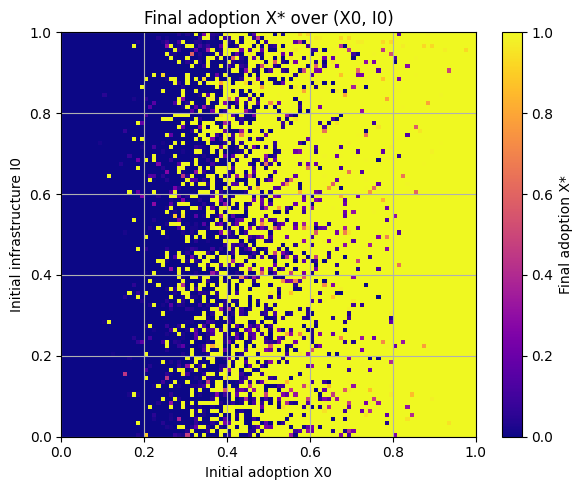

In [5]:
X_final = np.zeros((len(I0_vals), len(X0_vals)))

for i, I0 in enumerate(I0_vals):
    for j, X0 in enumerate(X0_vals):
        finals = []
        for r in range(N_SEEDS):
            seed = 1000 + 100*i + 10*j + r
            x_star = run_network_trial(
                X0_frac=X0,
                ratio=BASE["ratio"],
                I0=I0,
                beta_I=BASE["beta_I"],
                b=BASE["b"],
                g_I=BASE["g_I"],
                T=T,
                network_type=BASE["network_type"],
                n_nodes=BASE["n_nodes"],
                m=BASE["m"],
                seed=seed,
                collect=False,
                strategy_choice_func="logit", 
                tau=3.0,
            )
            finals.append(x_star)
        X_final[i, j] = np.mean(finals)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(
    X_final,
    origin="lower",
    extent=[X0_vals[0], X0_vals[-1], I0_vals[0], I0_vals[-1]],
    aspect="auto",
    vmin=0.0, vmax=1.0,
    cmap="plasma",
)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Final adoption X*")
ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Initial infrastructure I0")
ax.set_title("Final adoption X* over (X0, I0)")
plt.tight_layout()
plt.savefig("heatmap_X0_I0.png", dpi=150)
plt.show()


## Heatmap with separatrix

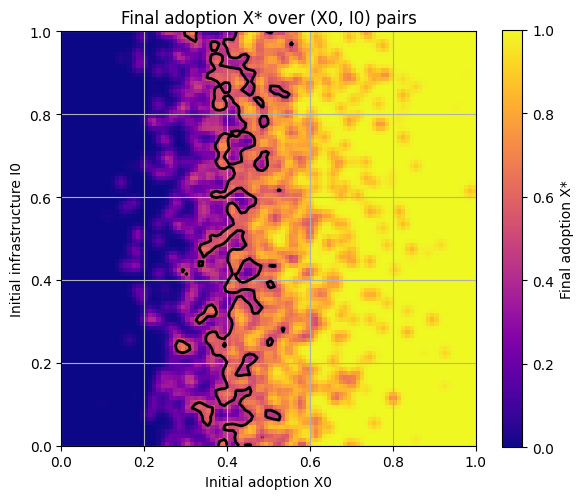

In [6]:
X0s, I0s = np.meshgrid(X0_vals, I0_vals)

final_grid = np.zeros_like(X0s)

for i in range(X0s.shape[0]):         # loop over I0 dimension
    for j in range(X0s.shape[1]):     # loop over X0 dimension

        X0 = X0s[i, j]
        I0 = I0s[i, j]

        f_vals = []
        for r in range(N_SEEDS):
            seed = 22 * (i * X0s.shape[1] + j)

            x_star = run_network_trial(
                X0_frac=X0,
                I0=I0,
                ratio=BASE["ratio"],
                beta_I=BASE["beta_I"],
                b=BASE["b"],
                g_I=BASE["g_I"],
                T=T,
                network_type=BASE["network_type"],
                n_nodes=BASE["n_nodes"],
                m=BASE["m"],
                seed=seed,
                collect=False,
                strategy_choice_func="logit",
                tau=3.0,
            )
            f_vals.append(x_star)

        final_grid[i, j] = np.mean(f_vals)

from scipy.ndimage import gaussian_filter

# smooth the grid to remove stochastic discontinuities
final_smooth = gaussian_filter(final_grid, sigma=1.0)

fig, ax = plt.subplots(figsize=(6,5))

# continuous heatmap
im = ax.imshow(
    final_smooth,
    origin='lower',
    extent=[0,1,0,1],
    cmap='plasma',
    vmin=0,
    vmax=1
)

# separatrix
CS = ax.contour(
    X0s, I0s, final_smooth,
    levels=[0.5],
    colors='black',
    linewidths=2
)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Initial infrastructure I0")
ax.set_title("Final adoption X* over (X0, I0) pairs")
plt.colorbar(im, ax=ax, label="Final adoption X*")
plt.tight_layout()
plt.show()

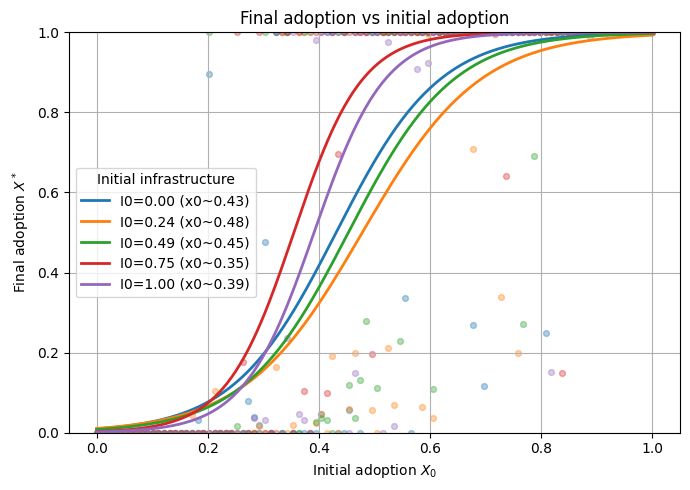

In [8]:
def logistic(x, k, x0):
    # ranges from 0 to 1
    return 1.0 / (1.0 + np.exp(-k * (x - x0)))

idxs = np.linspace(0, len(I0_vals) - 1, 5, dtype=int)
I0_sel = I0_vals[idxs]

x = np.asarray(X0_vals)
x_dense = np.linspace(x.min(), x.max(), 400)

plt.figure(figsize=(7, 5))

for idx, I0 in zip(idxs, I0_sel):
    y = np.asarray(X_final[idx, :])

    plt.scatter(x, y, s=18, alpha=0.35)

    # initial guesses: slope k ~ 10, midpoint at median X0
    p0 = (10.0, np.median(x))
    try:
        (k_hat, x0_hat), _ = curve_fit(logistic, x, y, p0=p0, maxfev=20000)
        y_hat = logistic(x_dense, k_hat, x0_hat)
        plt.plot(x_dense, y_hat, linewidth=2, label=f"I0={I0:.2f} (x0~{x0_hat:.2f})")
    except RuntimeError:
        # if fit fails, just skip the curve
        plt.plot([], [], label=f"I0={I0:.2f} (fit failed)")

plt.xlabel("Initial adoption $X_0$")
plt.ylabel("Final adoption $X^*$")
plt.title("Final adoption vs initial adoption")
plt.ylim(0, 1)
plt.legend(title="Initial infrastructure")
plt.grid(True)
plt.tight_layout()
plt.show()


## Sensitivity of system to $\beta_i$

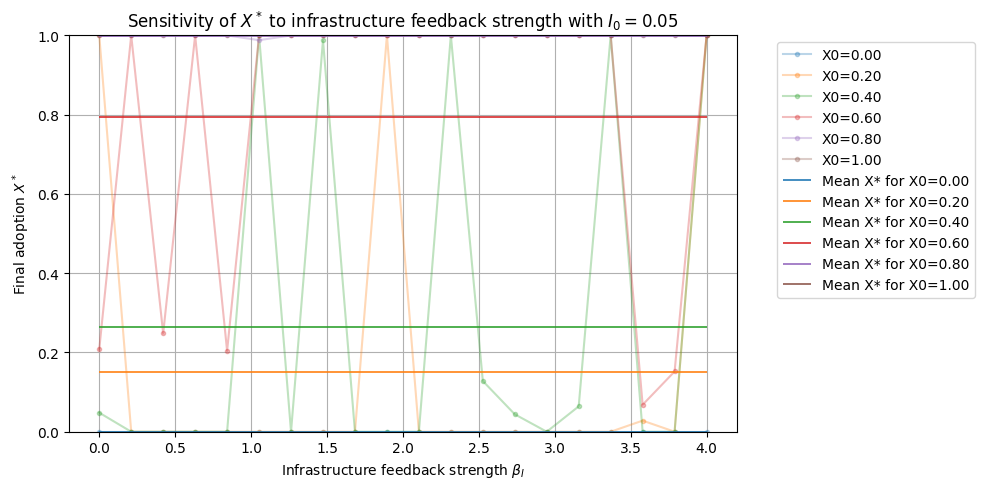

In [9]:
beta_vals = np.linspace(0.0, 4.0, 20)
X0_vals_test = [0,0.2, 0.4, 0.6, 0.8, 1.0]

n_x0   = len(X0_vals_test)
n_beta = len(beta_vals)

sens = np.zeros((n_x0, n_beta))

for j, beta in enumerate(beta_vals):
    for i, X0 in enumerate(X0_vals_test):

        x_star_vals = [] #terrible name

        for r in range(N_SEEDS):
            # Deterministic seed depending on beta index, X0 index, and replicate
            seed = 1_000_000 + 10_000 * r + 100 * j + i

            x_star = run_network_trial(
                X0_frac=X0,
                ratio=BASE["ratio"],
                I0=BASE["I0"],
                beta_I=beta,
                b=BASE["b"],
                g_I=BASE["g_I"],
                T=T,
                network_type=BASE["network_type"],
                n_nodes=BASE["n_nodes"],
                m=BASE["m"],
                seed=seed,
                collect=False,
                strategy_choice_func="logit",
                tau=3.0,
            )

            x_star_vals.append(x_star)

        sens[i, j] = np.mean(x_star_vals)

fig, ax = plt.subplots(figsize=(10, 5))

for i, X0 in enumerate(X0_vals_test):
    ax.plot(beta_vals, sens[i, :], alpha = 0.3, marker=".", label=f"X0={X0:.2f}")

# Plot a horizontal line for each X0's average
sens_avg = sens.mean(axis=1)   # shape: (n_x0,)

# Horizontal mean line for each X0 in matching color
for i, avg in enumerate(sens_avg):
    curve_color = ax.lines[i].get_color()   # <-- extract the original curve color
    ax.hlines(
        y=avg,
        xmin=beta_vals.min(),
        xmax=beta_vals.max(),
        colors=curve_color,
        linestyles="-",
        linewidth=1.3,
        alpha=0.9,
        label=f"Mean X* for X0={X0_vals_test[i]:.2f}",
    )
# Can you plot average final adoption across average over all beta values as well?

ax.set_xlabel(r"Infrastructure feedback strength $\beta_I$")
ax.set_ylabel(r"Final adoption $X^*$")
ax.set_ylim(0, 1)
ax.set_title(rf"Sensitivity of $X^*$ to infrastructure feedback strength with $I_0={BASE['I0']}$")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.savefig("sensitivity_betaI.png", dpi=150)
plt.show()

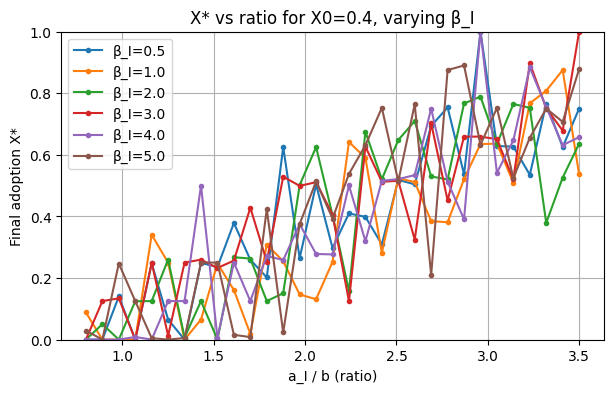

In [10]:
beta_values = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]
ratio_values_beta = np.linspace(0.8, 3.5, 31)
X0_fixed = 0.4
batch_size = 8

sensitivity_results = []

for beta_I in beta_values:
    # Start from BASE and override what you’re sweeping
    scenario_beta = BASE.copy()
    scenario_beta.update({"beta_I": beta_I})

    sweep_df = ratio_sweep_df(
        X0_frac=X0_fixed,
        ratio_values=ratio_values_beta,
        scenario_kwargs=scenario_beta,
        T=T,
        batch_size=batch_size,
        init_noise_I=0.04,
        strategy_choice_func="logit",
        tau=1.0,
    )
    sweep_df["beta_I"] = beta_I
    sensitivity_results.append(sweep_df)

beta_sensitivity_df = pd.concat(sensitivity_results, ignore_index=True)

# Plotting
fig, ax = plt.subplots()

for beta_I in beta_values:
    df_beta = beta_sensitivity_df[beta_sensitivity_df["beta_I"] == beta_I]
    ax.plot(df_beta["ratio"], df_beta["X_mean"], marker=".", label=f"β_I={beta_I}")

ax.set_xlabel("a_I / b (ratio)")
ax.set_ylabel("Final adoption X*")
ax.set_title(f"X* vs ratio for X0={X0_fixed}, varying β_I")
ax.set_ylim(0, 1)
ax.legend()
plt.show()


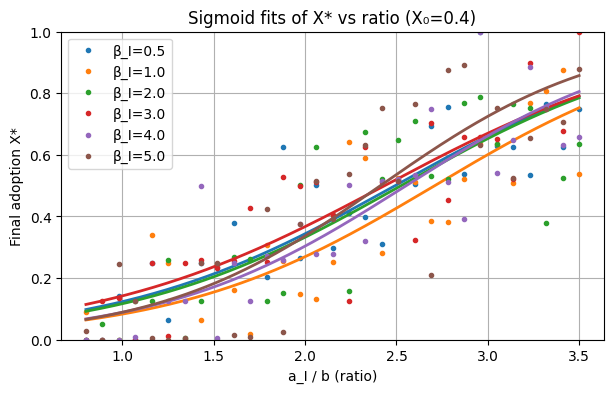

In [11]:
fig, ax = plt.subplots()

r_fine = np.linspace(ratio_values_beta.min(), ratio_values_beta.max(), 300)

fit_params = {}

# get a color cycle we control
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, beta_I in enumerate(beta_values):
    df_beta = beta_sensitivity_df[beta_sensitivity_df["beta_I"] == beta_I]

    r = df_beta["ratio"].values
    X = df_beta["X_mean"].values

    color = colors[i % len(colors)]

    # raw data
    ax.plot(
        r, X,
        marker=".",
        linestyle="none",
        color=color,
        label=f"β_I={beta_I}",
    )

    # fit
    p0 = [np.median(r), 5.0]
    popt, _ = curve_fit(
        sigmoid, r, X,
        p0=p0,
        bounds=([0, 0], [10, 50]),
    )

    r0, k = popt
    fit_params[beta_I] = {"r0": r0, "k": k}

    # fitted curve (same color)
    ax.plot(
        r_fine,
        sigmoid(r_fine, *popt),
        linewidth=2,
        color=color,
    )

ax.set_xlabel("a_I / b (ratio)")
ax.set_ylabel("Final adoption X*")
ax.set_title(f"Sigmoid fits of X* vs ratio (X₀={X0_fixed})")
ax.set_ylim(0, 1)
ax.legend()
plt.show()


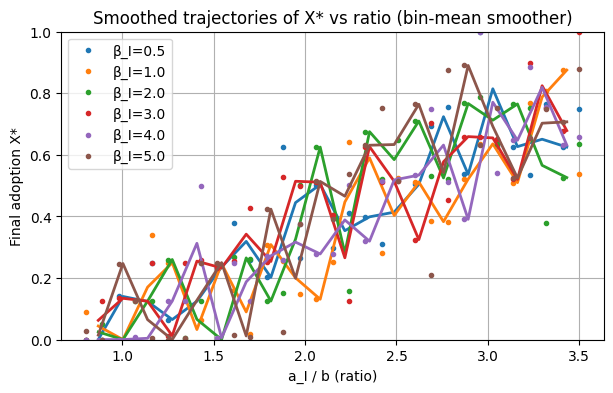

In [12]:
def smooth_binned(x, y, n_bins=25):
    # sort
    order = np.argsort(x)
    x, y = x[order], y[order]

    # bin and average
    bins = np.linspace(x.min(), x.max(), n_bins + 1)
    centers = 0.5 * (bins[:-1] + bins[1:])
    y_s = np.full(n_bins, np.nan)

    for i in range(n_bins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if mask.any():
            y_s[i] = y[mask].mean()

    good = np.isfinite(y_s)
    return centers[good], y_s[good]

fig, ax = plt.subplots()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, beta_I in enumerate(beta_values):
    df_beta = beta_sensitivity_df[beta_sensitivity_df["beta_I"] == beta_I].copy()
    df_beta = df_beta.sort_values("ratio").groupby("ratio", as_index=False)["X_mean"].mean()

    r = df_beta["ratio"].to_numpy(float)
    X = df_beta["X_mean"].to_numpy(float)

    c = colors[i % len(colors)]
    ax.plot(r, X, ".", color=c, label=f"β_I={beta_I}")

    xs, ys = smooth_binned(r, X, n_bins=20)
    ax.plot(xs, ys, linewidth=2, color=c)

ax.set_xlabel("a_I / b (ratio)")
ax.set_ylabel("Final adoption X*")
ax.set_title("Smoothed trajectories of X* vs ratio (bin-mean smoother)")
ax.set_ylim(0, 1)
ax.legend()
plt.show()


Running sweep for network type: grid
Running sweep for network type: WS
Running sweep for network type: BA
Running sweep for network type: ER


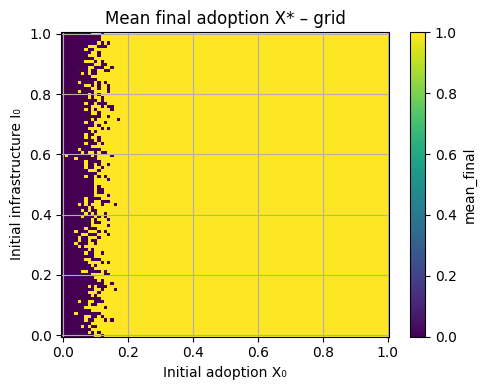

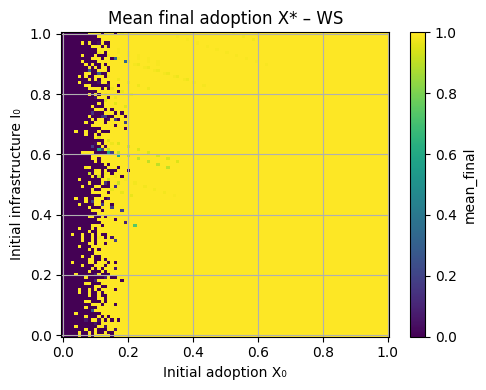

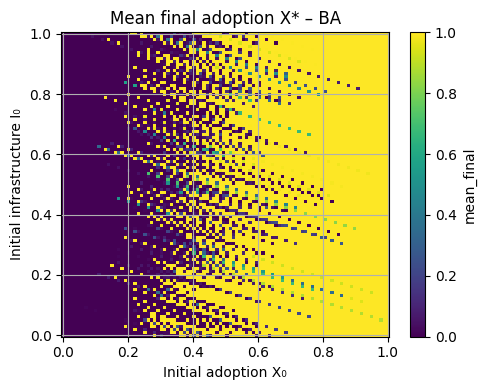

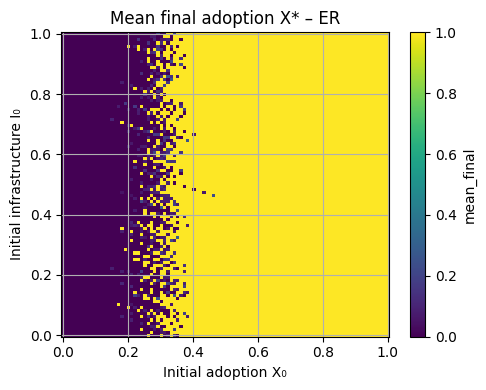

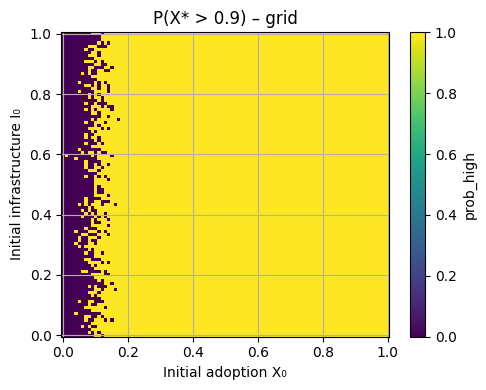

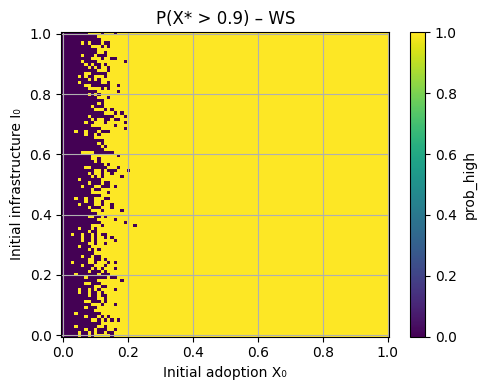

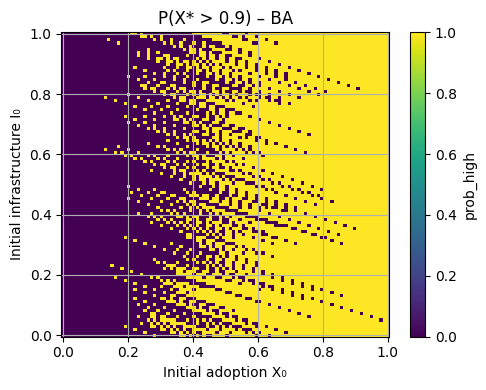

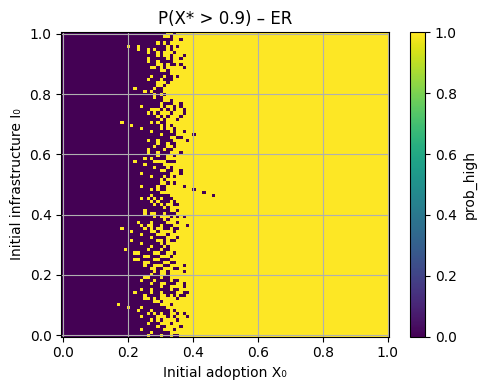

In [13]:
# NOTE: The strings must match what your code expects in run_network_trial.
NETWORK_TYPES = [
    "grid",       # local interactions (2D lattice)
    "WS",         # small-world (Watts–Strogatz style)
    "BA",         # scale-free (Barabási–Albert)
    "ER",         # Erdős–Rényi
]

def summarize_condition(network_type, X0, I0, base_params, T=250, N_seeds=5,
                        high_thresh=0.9):
    """
    Run multiple stochastic trials for one (network_type, X0, I0) triple.
    Returns: mean_final, std_final, prob_high
    """
    finals = []

    for r in range(N_seeds):
        # Any deterministic but varying seed is fine
        seed = int(1e6 * (X0 + 3*I0 + r))

        x_star = run_network_trial(
            X0_frac=X0,
            I0=I0,
            ratio=base_params["ratio"],
            beta_I=base_params["beta_I"],
            b=base_params["b"],
            g_I=base_params["g_I"],
            T=T,
            network_type=network_type,
            n_nodes=base_params["n_nodes"],
            m=base_params["m"],
            seed=seed,
            collect=False,
            strategy_choice_func="logit",
            tau=base_params.get("tau", 3.0),
        )
        finals.append(x_star)

    finals = np.array(finals)
    mean_final = finals.mean()
    std_final = finals.std()
    prob_high = (finals > high_thresh).mean()

    return mean_final, std_final, prob_high

all_results = []

for net in NETWORK_TYPES:
    print(f"Running sweep for network type: {net}")

    for X0 in X0_vals:
        for I0 in I0_vals:
            mean_final, std_final, prob_high = summarize_condition(
                network_type=net,
                X0=X0,
                I0=I0,
                base_params=BASE,
                T=T,
                N_seeds=N_SEEDS,
            )

            all_results.append({
                "network_type": net,
                "X0": X0,
                "I0": I0,
                "mean_final": mean_final,
                "std_final": std_final,
                "prob_high": prob_high,
            })

network_results_df = pd.DataFrame(all_results)
network_results_df.head()

def plot_heatmap_for_network(df, value_col, title_suffix, vmin=0.0, vmax=1.0):
    X0_unique = np.sort(df["X0"].unique())
    I0_unique = np.sort(df["I0"].unique())

    pivot = df.pivot(index="I0", columns="X0", values=value_col)
    X0_grid, I0_grid = np.meshgrid(X0_unique, I0_unique)

    plt.figure(figsize=(5, 4))
    im = plt.pcolormesh(X0_grid, I0_grid, pivot.values,
                        shading="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=value_col)
    plt.xlabel("Initial adoption X₀")
    plt.ylabel("Initial infrastructure I₀")
    plt.title(title_suffix)
    plt.tight_layout()
    plt.show()

for net in network_results_df["network_type"].unique():
    df_net = network_results_df[network_results_df["network_type"] == net]
    plot_heatmap_for_network(
        df_net,
        value_col="mean_final",
        title_suffix=f"Mean final adoption X* – {net}",
        vmin=0.0,
        vmax=1.0,
    )

for net in network_results_df["network_type"].unique():
    df_net = network_results_df[network_results_df["network_type"] == net]
    plot_heatmap_for_network(
        df_net,
        value_col="prob_high",
        title_suffix=f"P(X* > 0.9) – {net}",
        vmin=0.0,
        vmax=1.0,
    )

# # Choose some I0 values to slice on (use ones actually in I0_vals)
# I0_slice_values = [0.1, 0.5]

# for I0_target in I0_slice_values:
#     plt.figure(figsize=(6, 4))

#     for net in network_results_df["network_type"].unique():
#         df_net = network_results_df[
#             (network_results_df["network_type"] == net) &
#             (np.isclose(network_results_df["I0"], I0_target))
#         ].sort_values("X0")

#         plt.plot(df_net["X0"], df_net["prob_high"],
#                  marker="o", label=net)

#     plt.xlabel("Initial adoption X₀")
#     plt.ylabel("P(X* > 0.9)")
#     plt.title(f"Tipping curves at I₀ ≈ {I0_target}")
#     plt.legend(title="Network")
#     plt.ylim(-0.05, 1.05)
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()
    

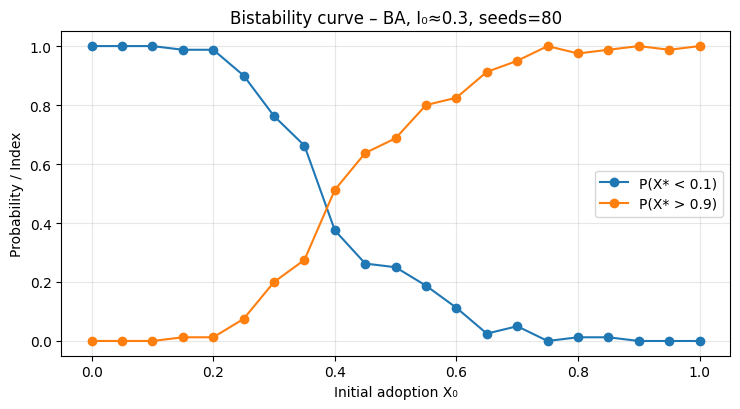

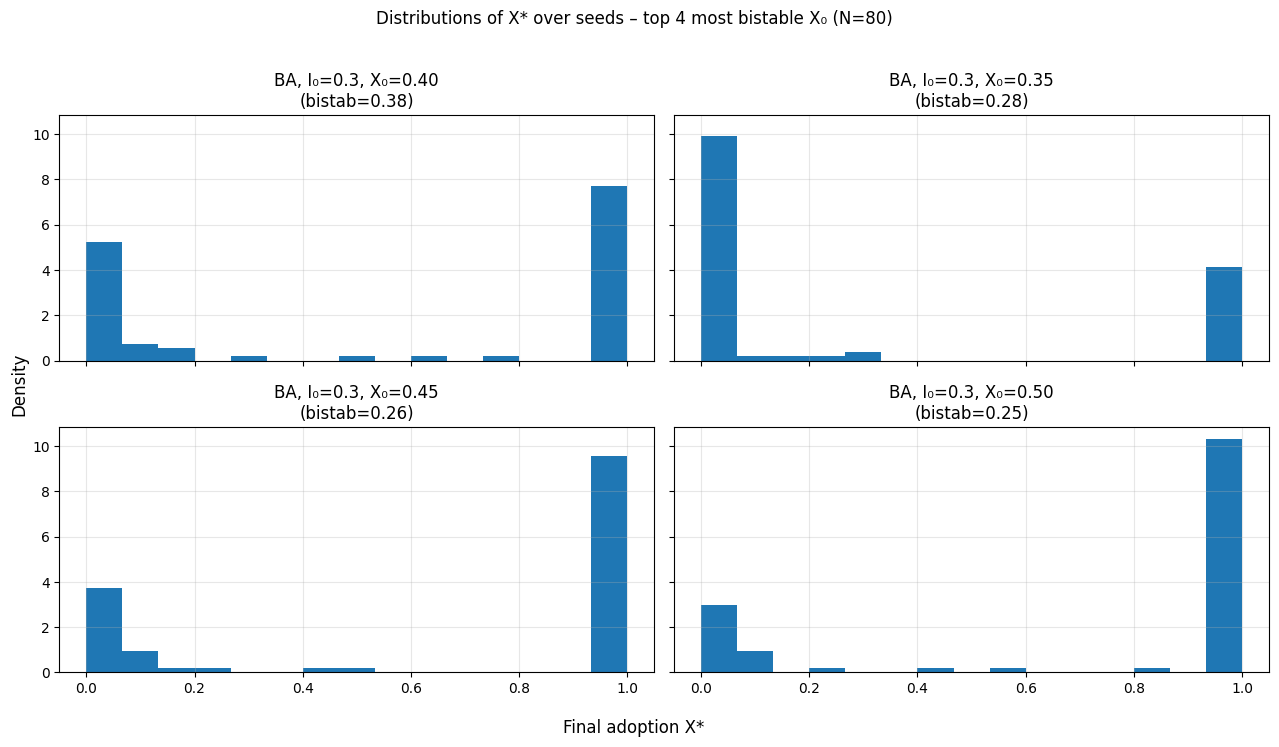

,network_type,X0,I0,mean_final,std_final,p_low,p_high,bistability_index,prob_high
0,BA,0.00,0.3,0.00000,0.000000,1.0000,0.0000,0.0000,0.0000
1,BA,0.05,0.3,0.00000,0.000000,1.0000,0.0000,0.0000,0.0000
2,BA,0.10,0.3,0.00040,0.003555,1.0000,0.0000,0.0000,0.0000
3,BA,0.15,0.3,0.01250,0.111102,0.9875,0.0125,0.0125,0.0125
4,BA,0.20,0.3,0.01280,0.111101,0.9875,0.0125,0.0125,0.0125
5,BA,0.25,0.3,0.08150,0.262420,0.9000,0.0750,0.0750,0.0750
6,BA,0.30,0.3,0.20860,0.396170,0.7625,0.2000,0.2000,0.2000
7,BA,0.35,0.3,0.29390,0.437939,0.6625,0.2750,0.2750,0.2750
8,BA,0.40,0.3,0.55500,0.471601,0.3750,0.5125,0.3750,0.5125
9,BA,0.45,0.3,0.66300,0.452316,0.2625,0.6375,0.2625,0.6375


In [14]:
NET = "BA"          # one of: "grid", "WS", "BA", "ER"
I0_TARGET = 0.30    # pick an I0 slice value that exists / is meaningful
X0_VALS = np.linspace(0.0, 1.0, 21)

N_SEEDS = 80        # increase (e.g., 150-300) if the curve is noisy
LOW_THR = 0.10
HIGH_THR = 0.90
T_FINAL = T if "T" in globals() else 250

# how many X0 points to show histograms for:
N_HIST = 4          # plots the most "bistable" X0s
HIST_BINS = 15
# ==========================================

# --- helpers ---
def run_condition_distribution(network_type, X0, I0, base_params, T=250, N_seeds=50):
    finals = []
    for r in range(N_seeds):
        seed = int(1e6 * (X0 + 3*I0 + r))
        x_star = run_network_trial(
            X0_frac=float(X0),
            I0=float(I0),
            ratio=base_params["ratio"],
            beta_I=base_params["beta_I"],
            b=base_params["b"],
            g_I=base_params["g_I"],
            T=T,
            network_type=network_type,
            n_nodes=base_params["n_nodes"],
            m=base_params["m"],
            seed=seed,
            collect=False,
            strategy_choice_func="logit",
            tau=base_params.get("tau", 3.0),
        )
        finals.append(x_star)
    return np.array(finals, dtype=float)

def bistability_stats(finals, low_thresh=0.1, high_thresh=0.9):
    p_low = (finals < low_thresh).mean()
    p_high = (finals > high_thresh).mean()
    bistab = min(p_low, p_high)  # large only if BOTH low & high outcomes occur
    return p_low, p_high, bistab

# --- run sweep ---
rows = []
finals_by_X0 = {}

for X0 in X0_VALS:
    finals = run_condition_distribution(NET, X0, I0_TARGET, BASE, T=T_FINAL, N_seeds=N_SEEDS)
    p_low, p_high, bistab = bistability_stats(finals, low_thresh=LOW_THR, high_thresh=HIGH_THR)

    rows.append({
        "network_type": NET,
        "X0": float(X0),
        "I0": float(I0_TARGET),
        "mean_final": finals.mean(),
        "std_final": finals.std(),
        "p_low": p_low,
        "p_high": p_high,
        "bistability_index": bistab,
        # also keep your original "prob_high" style metric:
        "prob_high": (finals > HIGH_THR).mean(),
    })
    finals_by_X0[float(X0)] = finals

bistab_df = pd.DataFrame(rows).sort_values("X0").reset_index(drop=True)

# --- plot bistability curve ---
plt.figure(figsize=(7.5, 4.2))
plt.plot(bistab_df["X0"], bistab_df["p_low"], marker="o", label=f"P(X* < {LOW_THR})")
plt.plot(bistab_df["X0"], bistab_df["p_high"], marker="o", label=f"P(X* > {HIGH_THR})")
# plt.plot(bistab_df["X0"], bistab_df["bistability_index"], marker="o", linewidth=3,
        #  label="bistability_index = min(p_low, p_high)")
plt.xlabel("Initial adoption X₀")
plt.ylabel("Probability / Index")
plt.title(f"Bistability curve – {NET}, I₀≈{I0_TARGET}, seeds={N_SEEDS}")
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# --- plot example distributions (histograms) in one figure (ax1/ax2/... style) ---
top_X0s = (
    bistab_df.sort_values("bistability_index", ascending=False)
             .head(N_HIST)["X0"]
             .tolist()
)

# nice layout: up to 4 => 2x2, otherwise make a roughly-square grid
n = len(top_X0s)
ncols = 2 if n <= 4 else int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(6.5 * ncols, 3.6 * nrows),
    sharex=True, sharey=True
)

# make axes always iterable
axes = np.atleast_1d(axes).ravel()

# use consistent bins across panels
bins = np.linspace(0.0, 1.0, HIST_BINS + 1)

for i, X0 in enumerate(top_X0s):
    ax = axes[i]
    finals = finals_by_X0[float(X0)]

    ax.hist(finals, bins=bins, density=True)
    ax.set_title(f"{NET}, I₀={I0_TARGET}, X₀={X0:.2f}\n(bistab={bistab_df.loc[bistab_df['X0']==X0,'bistability_index'].values[0]:.2f})")
    ax.grid(True, alpha=0.3)

# turn off any unused axes
for j in range(n, len(axes)):
    axes[j].axis("off")

# shared labels (only once)
fig.supxlabel("Final adoption X*")
fig.supylabel("Density")
fig.suptitle(f"Distributions of X* over seeds – top {n} most bistable X₀ (N={N_SEEDS})", y=1.02)

plt.tight_layout()
plt.show()



# --- optional: display the table so you can pick a nice X0 region ---
bistab_df

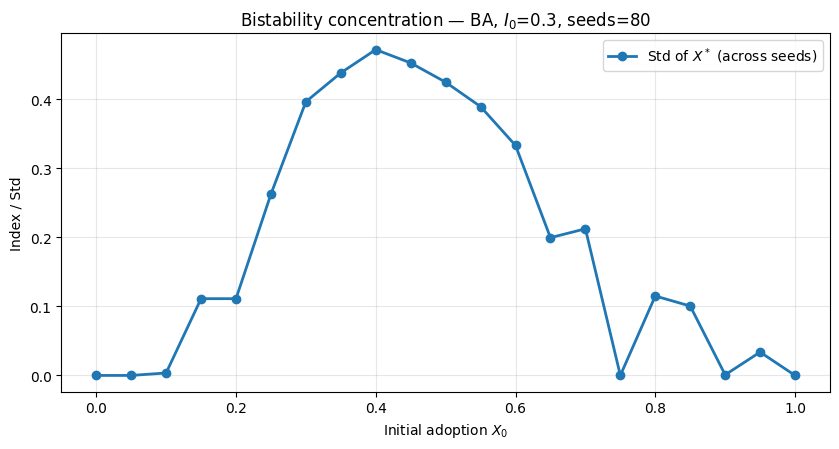

In [15]:
def sweep_small_perturbations_X0(
    network_type,
    X0_vals,
    I0,
    base_params,
    *,
    eps=0.02,                 # size of X0 perturbation
    mode="plusminus",         # "plusminus" or "plus"
    N_seeds=80,
    T=250,
    low_thr=0.10,
    high_thr=0.90,
    strategy_choice_func="logit",
    tau=None,
    clamp=True,
    seed_base=12345,
):
    """
    Examine effect of small perturbations around each X0 in X0_vals.
    
    For each X0:
      - runs N_seeds trials at baseline X0
      - runs N_seeds trials at perturbed X0 (+eps, and -eps if mode="plusminus")
      - uses paired seeds so differences are attributable to the perturbation, not RNG noise
    
    Returns:
      df: per-X0 summary metrics + local sensitivity stats
      raw: dict with raw finals arrays for deeper inspection/plots
    """
    if tau is None:
        tau = base_params.get("tau", 3.0)

    def _clamp01(x):
        return float(np.clip(x, 0.0, 1.0)) if clamp else float(x)

    def run_finals(X0_run, seeds):
        finals = []
        for s in seeds:
            finals.append(
                run_network_trial(
                    X0_frac=_clamp01(X0_run),
                    I0=float(I0),
                    ratio=base_params["ratio"],
                    beta_I=base_params["beta_I"],
                    b=base_params["b"],
                    g_I=base_params["g_I"],
                    T=T,
                    network_type=network_type,
                    n_nodes=base_params["n_nodes"],
                    m=base_params["m"],
                    seed=int(s),
                    collect=False,
                    strategy_choice_func=strategy_choice_func,
                    tau=tau,
                )
            )
        return np.array(finals, dtype=float)

    def probs(finals):
        p_low = (finals < low_thr).mean()
        p_high = (finals > high_thr).mean()
        p_mid = 1.0 - p_low - p_high
        return p_low, p_mid, p_high

    rows = []
    raw = {}

    # paired seeds reused across baseline/perturbed runs
    seeds = [seed_base + i for i in range(N_seeds)]

    for X0 in X0_vals:
        X0 = float(X0)
        X0p = _clamp01(X0 + eps)
        X0m = _clamp01(X0 - eps)

        f0 = run_finals(X0, seeds)
        std_final0 = float(np.std(f0))   # <-- ADD THIS LINE
        fp = run_finals(X0p, seeds)
        p_low0, p_mid0, p_high0 = probs(f0)
        p_lowp, p_midp, p_highp = probs(fp)

        # paired per-seed effect sizes
        d_plus = fp - f0

        # summary for +eps
        row = dict(
            network_type=network_type,
            I0=float(I0),
            X0=X0,
            eps=float(eps),
            X0_plus=X0p,
            mean0=f0.mean(),
            mean_plus=fp.mean(),
            delta_mean_plus=d_plus.mean(),
            delta_mean_plus_std=d_plus.std(),
            p_low0=p_low0, p_mid0=p_mid0, p_high0=p_high0,
            p_low_plus=p_lowp, p_mid_plus=p_midp, p_high_plus=p_highp,
            delta_p_high_plus=(p_highp - p_high0),
            delta_p_low_plus=(p_lowp - p_low0),
            std_final0=std_final0,
            # "flip rate": did a seed switch regime classification?
            flip_rate_plus=(
                ((f0 > high_thr) & (fp < low_thr)) |
                ((f0 < low_thr) & (fp > high_thr))
            ).mean(),
        )

        raw[(X0, "base")] = f0
        raw[(X0, "+")] = fp

        if mode == "plusminus":
            fm = run_finals(X0m, seeds)
            p_lowm, p_midm, p_highm = probs(fm)
            d_minus = f0 - fm  # effect of +eps if you move from X0-eps to X0 (same step size)

            row.update(dict(
                X0_minus=X0m,
                mean_minus=fm.mean(),
                delta_mean_minus=(f0 - fm).mean(),
                delta_mean_minus_std=(f0 - fm).std(),
                p_low_minus=p_lowm, p_mid_minus=p_midm, p_high_minus=p_highm,
                delta_p_high_minus=(p_high0 - p_highm),
                delta_p_low_minus=(p_low0 - p_lowm),
                # symmetric finite-difference derivative estimate:
                d_mean_dX0=((fp.mean() - fm.mean()) / (X0p - X0m)) if (X0p != X0m) else np.nan,
                d_p_high_dX0=((p_highp - p_highm) / (X0p - X0m)) if (X0p != X0m) else np.nan,
            ))
            raw[(X0, "-")] = fm

        rows.append(row)

    df = pd.DataFrame(rows).sort_values("X0").reset_index(drop=True)
    return df, raw


df_pert, raw_pert = sweep_small_perturbations_X0(
    network_type=NET,
    X0_vals=X0_VALS,
    I0=I0_TARGET,
    base_params=BASE,
    eps=0.02,
    mode="plusminus",
    N_seeds=N_SEEDS,
    T=T_FINAL,
    low_thr=LOW_THR,
    high_thr=HIGH_THR,
)
df_pert

x = bistab_df["X0"].values
bistab = np.minimum(bistab_df["p_low"].values, bistab_df["p_high"].values)

plt.figure(figsize=(8.5, 4.6))
plt.plot(x, bistab_df["std_final"].values, marker="o", linewidth=2, label="Std of $X^*$ (across seeds)")

plt.xlabel("Initial adoption $X_0$")
plt.ylabel("Index / Std")
plt.title(f"Bistability concentration — {NET}, $I_0$={I0_TARGET}, seeds={N_SEEDS}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:


def run_and_get_hist(X0, I0, seed, **kwargs):
    out = run_network_trial(
        X0_frac=X0,
        I0=I0,
        seed=seed,
        collect=True,                 # <-- key for time series
        strategy_choice_func="logit",
        tau=3.0,
        **kwargs
    )

    # Try common formats
    # 1) dict with keys
    if isinstance(out, dict):
        # common keys: 'X', 'I' or 'X_t', 'I_t'
        for Xk in ["X", "X_t", "X_series", "adoption", "x"]:
            for Ik in ["I", "I_t", "I_series", "infra", "i"]:
                if Xk in out and Ik in out:
                    return np.asarray(out[Xk]), np.asarray(out[Ik])
        # maybe it's a dataframe-like dict
        if "df" in out:
            df = out["df"]
            return np.asarray(df["X"]), np.asarray(df["I"])

    # 2) tuple/list: (x_star, history) or (X_hist, I_hist)
    if isinstance(out, (tuple, list)):
        # case: (X_hist, I_hist)
        if len(out) == 2 and np.ndim(out[0]) == 1 and np.ndim(out[1]) == 1:
            return np.asarray(out[0]), np.asarray(out[1])
        # case: (x_star, hist_dict)
        if len(out) >= 2 and isinstance(out[1], dict):
            h = out[1]
            for Xk in ["X", "X_t", "X_series", "adoption", "x"]:
                for Ik in ["I", "I_t", "I_series", "infra", "i"]:
                    if Xk in h and Ik in h:
                        return np.asarray(h[Xk]), np.asarray(h[Ik])

    raise ValueError(
        "Couldn't extract X(t) and I(t). "
        "Check what run_network_trial returns when collect=True and adjust keys."
    )


# Model Networks

In [18]:

def simulate_one_run_with_metrics(
    X0_frac,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    seed=None,
    network_type="random",
    n_nodes=250,
    p=0.05,
    m=2,
    strategy_choice_func="logit",
    tau=3.0,
) -> dict:
    a0 = ratio * b - beta_I * I0
    model = EVStagHuntModel(
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=False, 
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # set initial adopters using your helper
    if X0_frac > 0.0:
        set_initial_adopters(
            model,
            X0_frac,
            method="random",  # or "degree" if you want targeted seeding
            seed=seed,
        )

    time_to_80 = None
    X_series = []
    
    for t in range(T):
        model.step()
        X = model.get_adoption_fraction()
        X_series.append(X)
        if time_to_80 is None and X >= 0.8:
            time_to_80 = t

    final_X = X_series[-1]

    # ---- cluster formation at final time ----
    G = model.G
    ev_nodes = [agent.pos for agent in model.schedule.agents if agent.strategy == "C"]
    if ev_nodes:
        G_ev = G.subgraph(ev_nodes)
        if G_ev.number_of_nodes() > 0:
            components = nx.connected_components(G_ev)
            largest = max(len(comp) for comp in components)
            largest_cluster = largest / G.number_of_nodes()
        else:
            largest_cluster = 0.0
    else:
        largest_cluster = 0.0

    return {
        "final_X": float(final_X),
        "time_to_80": None if time_to_80 is None else int(time_to_80),
        "largest_cluster": float(largest_cluster),
    }

In [19]:
def run_topology_sweep(
    network_types=("small_world", "BA", "ER"),
    X0_values=np.linspace(0, 1, 16),
    n_trials_per_point=10,
    seed=42,
    **kwargs,
) -> pd.DataFrame:
    rows = []

    for net in network_types:
        for i, X0 in enumerate(X0_values):
            for r in range(n_trials_per_point):
                seed = int(1e6 * (X0 + r))
                metrics = simulate_one_run_with_metrics(
                    network_type=net,
                    X0_frac=X0,
                    seed=seed,
                    **kwargs,
                )
                rows.append(
                    {
                        "network": net,
                        "X0": X0,
                        "high_eq": metrics["final_X"] > 0.8,
                        **metrics,
                    }
                )

    return pd.DataFrame(rows)

T=250

df_topo = run_topology_sweep(
    network_types=("ER", "small_world", "BA"),
    X0_values=np.linspace(0, 1.0, 16),
    n_trials_per_point=10,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    n_nodes=250,
)

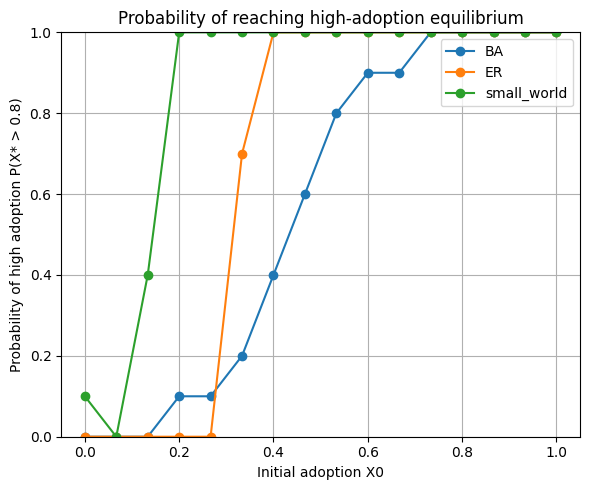

In [20]:
prob_high = (
    df_topo.groupby(["network", "X0"])["high_eq"]
    .mean()
    .reset_index(name="P_high")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in prob_high.groupby("network"):
    ax.plot(grp["X0"], grp["P_high"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Probability of high adoption P(X* > 0.8)")
ax.set_ylim(0, 1)
ax.set_title("Probability of reaching high-adoption equilibrium")
ax.legend()
plt.tight_layout()
plt.savefig("topology_P_high.png", dpi=150)
plt.show()

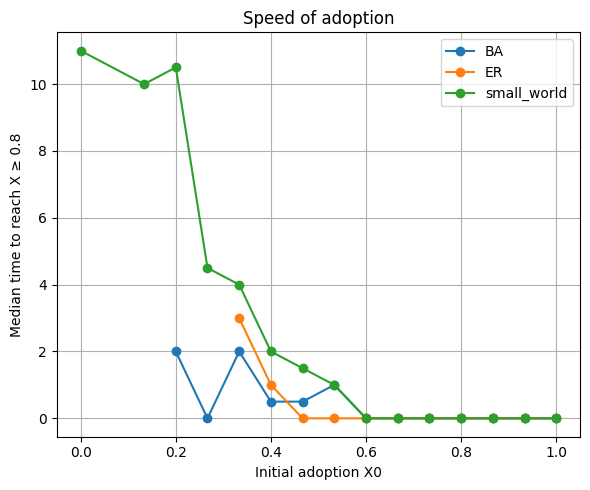

In [21]:
mask_success = df_topo["high_eq"] & df_topo["time_to_80"].notna()
speed = (
    df_topo[mask_success]
    .groupby(["network", "X0"])["time_to_80"]
    .median()
    .reset_index(name="median_time_to_80")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in speed.groupby("network"):
    ax.plot(grp["X0"], grp["median_time_to_80"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Median time to reach X ≥ 0.8")
ax.set_title("Speed of adoption")
ax.legend()
plt.tight_layout()
plt.savefig("topology_speed.png", dpi=150)
plt.show()

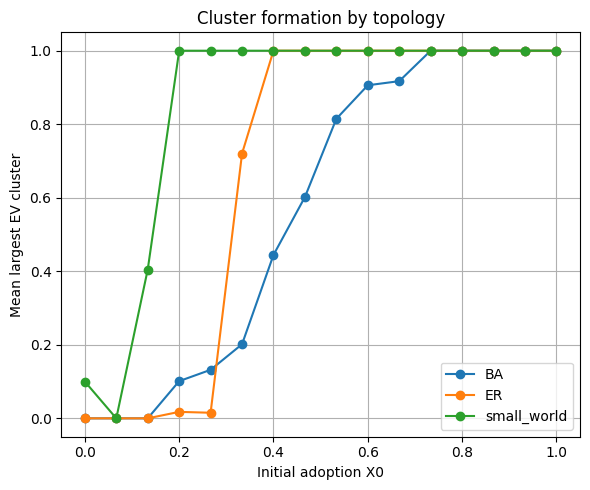

In [22]:
clusters = (
    df_topo.groupby(["network", "X0"])["largest_cluster"]
    .mean()
    .reset_index(name="mean_largest_cluster")
)

fig, ax = plt.subplots(figsize=(6,5))
for net, grp in clusters.groupby("network"):
    ax.plot(grp["X0"], grp["mean_largest_cluster"], marker="o", label=net)

ax.set_xlabel("Initial adoption X0")
ax.set_ylabel("Mean largest EV cluster")
ax.set_title("Cluster formation by topology")
ax.legend()
plt.tight_layout()
plt.savefig("topology_clusters.png", dpi=150)
plt.show()

In [23]:
def critical_X0_for_network(prob_high, net, target=0.5):
    g = prob_high[prob_high["network"] == net].sort_values("X0")
    # simple closest match
    idx = (g["P_high"] - target).abs().idxmin()
    return g.loc[idx, "X0"]

for net in prob_high["network"].unique():
    xcrit = critical_X0_for_network(prob_high, net, target=0.5)
    print(f"{net}: X0_crit ≈ {xcrit:.2f}")

BA: X0_crit ≈ 0.40
ER: X0_crit ≈ 0.33
small_world: X0_crit ≈ 0.13


# PROPOSED INTERVENTION 

- 

In [24]:
def apply_degree_targeted_seeding(model, frac: float, seed: int) -> int:
    """
    Convert a fraction `frac` of the highest-degree ICE ("D") nodes to EV ("C"),
    with random tie-breaking among nodes of equal degree.

    Returns the number of agents converted.
    """
    rng = np.random.RandomState(seed)
    G = model.G

    node_to_agent = {ag.pos: ag for ag in model.schedule.agents}
    ice_nodes = [n for n, ag in node_to_agent.items() if ag.strategy == "D"]
    if not ice_nodes:
        return 0

    N = len(node_to_agent)
    k = max(1, int(frac * N))
    k = min(k, len(ice_nodes))

    deg = dict(G.degree(ice_nodes))

    # sort by degree desc
    nodes_sorted = sorted(ice_nodes, key=deg.get, reverse=True)

    # shuffle within equal-degree blocks
    tied_sorted = []
    for d, group in groupby(nodes_sorted, key=deg.get):
        block = list(group)
        rng.shuffle(block)
        tied_sorted.extend(block)

    chosen = tied_sorted[:k]

    for n in chosen:
        node_to_agent[n].strategy = "C"

    return k

In [25]:
def apply_targeted_seeding(
    model,
    frac: float,
    seed: int,
    strategy: str = "degree",
    tie_break: str = "random",
    weight: str | None = None,
    max_iter_eigen: int = 2000,
    tol_eigen: float = 1e-6,
    k_approx_betweenness: int | None = None,
) -> dict:
    """
    Convert a fraction `frac` of *ICE* nodes ("D") to EV ("C") using a chosen targeting strategy.

    Parameters
    ----------
    model : EVStagHuntModel
        Must expose model.G (networkx graph) and model.schedule.agents (agents with .pos and .strategy).
    frac : float
        Fraction of TOTAL nodes to convert (e.g. 0.05 converts ~5% of all nodes).
    seed : int
        RNG seed (used for random strategy and for tie-breaking).
    strategy : str
        One of:
          - "degree"        : target highest degree nodes
          - "betweenness"   : target highest betweenness centrality nodes
          - "closeness"     : target highest closeness centrality nodes
          - "eigenvector"   : target highest eigenvector centrality nodes
          - "random"        : randomly choose ICE nodes
    tie_break : str
        How to break ties among equal scores for targeted strategies:
          - "random" (default): shuffle within equal-score groups using seed
          - "stable"         : keep deterministic sort order
    weight : str | None
        Optional edge attribute name to use as weight for centrality computations (when supported).
    max_iter_eigen, tol_eigen : eigenvector centrality params
    k_approx_betweenness : int | None
        If provided, uses nx.betweenness_centrality(G, k=..., seed=...) approximation
        to speed up on large graphs.

    Returns
    -------
    info : dict
        {
          "n_total": int,
          "n_ice": int,
          "k_requested": int,
          "k_applied": int,
          "strategy": str,
          "chosen_nodes": list,
          "chosen_scores": list,
        }
    """
    rng = np.random.RandomState(seed)
    G = model.G

    # --- node -> agent mapping ---
    node_to_agent = {ag.pos: ag for ag in model.schedule.agents}
    nodes_all = list(node_to_agent.keys())
    N = len(nodes_all)

    # --- ICE nodes only ---
    ice_nodes = [n for n, ag in node_to_agent.items() if ag.strategy == "D"]
    n_ice = len(ice_nodes)

    if n_ice == 0 or N == 0:
        return {
            "n_total": N,
            "n_ice": n_ice,
            "k_requested": 0,
            "k_applied": 0,
            "strategy": strategy,
            "chosen_nodes": [],
            "chosen_scores": [],
        }

    # --- how many to convert (fraction of TOTAL nodes, like your original code) ---
    k_requested = max(1, int(frac * N))
    k_applied = min(k_requested, n_ice)

    # --- scoring function for targeted strategies ---
    strategy = strategy.lower().strip()

    if strategy == "random":
        chosen_nodes = list(rng.choice(ice_nodes, size=k_applied, replace=False))
        chosen_scores = [None] * len(chosen_nodes)

    else:
        # Compute a score for EVERY node (or at least for ICE nodes), then select top ICE nodes by score.

        if strategy == "degree":
            scores = dict(G.degree(weight=weight))  # weight ignored unless your graph has weighted degrees

        elif strategy == "betweenness":
            # Full betweenness can be expensive; approximation optional
            if k_approx_betweenness is None:
                scores = nx.betweenness_centrality(G, weight=weight, normalized=True)
            else:
                scores = nx.betweenness_centrality(
                    G, k=k_approx_betweenness, seed=seed, weight=weight, normalized=True
                )

        elif strategy == "closeness":
            # networkx closeness_centrality supports distance=... for weighted shortest paths
            scores = nx.closeness_centrality(G, distance=weight)

        elif strategy == "eigenvector":
            # Can fail to converge on some graphs; set max_iter/tol
            scores = nx.eigenvector_centrality(
                G, max_iter=max_iter_eigen, tol=tol_eigen, weight=weight
            )

        else:
            raise ValueError(
                f"Unknown strategy '{strategy}'. "
                "Use one of: degree, betweenness, closeness, eigenvector, random."
            )

        # Only consider ICE nodes for selection
        ice_scores = {n: scores.get(n, 0.0) for n in ice_nodes}

        # Sort ICE nodes by score descending
        sorted_nodes = sorted(ice_nodes, key=ice_scores.get, reverse=True)

        if tie_break == "random":
            # Shuffle within equal-score blocks to make seed matter
            # (robust to float scores by grouping with rounding)
            def key_round(n):
                return round(float(ice_scores[n]), 12)

            # groupby needs pre-sorted by the key; we already are in descending score order
            # but groupby groups consecutive equal keys, so we use rounded keys.
            tied = []
            i = 0
            while i < len(sorted_nodes):
                s0 = key_round(sorted_nodes[i])
                j = i + 1
                while j < len(sorted_nodes) and key_round(sorted_nodes[j]) == s0:
                    j += 1
                block = sorted_nodes[i:j]
                rng.shuffle(block)
                tied.extend(block)
                i = j
            sorted_nodes = tied

        # Take top k_applied
        chosen_nodes = sorted_nodes[:k_applied]
        chosen_scores = [ice_scores[n] for n in chosen_nodes]

    # --- apply conversion ---
    for n in chosen_nodes:
        node_to_agent[n].strategy = "C"

    return {
        "n_total": N,
        "n_ice": n_ice,
        "k_requested": k_requested,
        "k_applied": len(chosen_nodes),
        "strategy": strategy,
        "chosen_nodes": chosen_nodes,
        "chosen_scores": chosen_scores,
    }


In [26]:
def simulate_with_targeted_seeding(
    network_type,
    X0_frac,
    seed,
    T=250,
    ratio=2.3,
    beta_I=2.0,
    b=1.0,
    g_I=0.005,
    I0=0.05,
    n_nodes=250,
    p=0.05,
    m=2,
    strategy_choice_func="logit",
    tau=3.0,
    # intervention parameters:
    intervention_time=None,          # e.g. 10, 50, 150 or None
    intervention_frac=0.0,           # e.g. 0.02, 0.05, 0.10
    intervention_strategy="degree",  # "degree", "betweenness", "closeness", "eigenvector", "random"
    intervention_kwargs=None,        # extra kwargs forwarded to apply_targeted_seeding
) -> dict:
    """
    Run one simulation and (optionally) apply a targeted seeding intervention
    using apply_targeted_seeding(...).

    Returns dict with:
        final_X, time_to_80, largest_cluster
    """
    intervention_kwargs = intervention_kwargs or {}

    a0 = ratio * b - beta_I * I0
    model = EVStagHuntModel(
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=False,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    # initial random adoption at t=0
    if X0_frac > 0.0:
        set_initial_adopters(
            model,
            X0_frac,
            method="random",
            seed=seed,
        )

    time_to_80 = None
    X_series = []

    for t in range(T):
        # timed targeted intervention (now strategy-agnostic)
        if (
            intervention_time is not None
            and t == intervention_time
            and intervention_frac > 0.0
        ):
            # separate RNG stream for intervention if you want
            intervention_seed = seed + 99999

            apply_targeted_seeding(
                model=model,
                frac=intervention_frac,
                seed=intervention_seed,
                strategy=intervention_strategy,
                **intervention_kwargs,
            )

        model.step()
        X = model.get_adoption_fraction()
        X_series.append(X)
        if time_to_80 is None and X >= 0.8:
            time_to_80 = t

    final_X = X_series[-1]

    # cluster formation at final time
    G = model.G
    agents = list(model.schedule.agents)
    ev_nodes = [ag.pos for ag in agents if ag.strategy == "C"]

    if ev_nodes:
        G_ev = G.subgraph(ev_nodes)
        if G_ev.number_of_nodes() > 0:
            components = nx.connected_components(G_ev)
            largest = max(len(c) for c in components)
            largest_cluster = largest / G.number_of_nodes()
        else:
            largest_cluster = 0.0
    else:
        largest_cluster = 0.0

    return {
        "final_X": float(final_X),
        "time_to_80": None if time_to_80 is None else int(time_to_80),
        "largest_cluster": float(largest_cluster),
    }

In [28]:
def run_intervention_sweep(
    network_types=("small_world", "BA", "random"),
    X0_frac=0.15,
    timings=(None, 10, 50, 150),               # None = baseline
    intensities=(0.02, 0.05, 0.10),            # used when timing is not None
    strategies=("degree","betweenness","random"),                    # e.g. ("degree","betweenness","random")
    n_trials_per_setting=10,
    base_seed=100,
    intervention_kwargs=None,                  # forwarded to apply_targeted_seeding
    **kwargs,                                  # forwarded to simulate_with_targeted_seeding / model args
) -> pd.DataFrame:
    """
    Run baseline + timed targeted-seeding interventions across networks.

    Baseline is repeated ONCE PER STRATEGY (same number of trials),
    so you can facet/compare cleanly by `seed_strategy` without missing baselines.

    One row per stochastic run with metrics + (network, timing, intensity, seed_strategy).
    - baseline rows have: timing=None, intensity=0.0, label="baseline"
    - intervention rows have: timing=t_int, intensity=frac, label="intervention"
    """
    rng = np.random.default_rng(base_seed)
    rows = []
    intervention_kwargs = intervention_kwargs or {}

    timings_clean = [t for t in timings if t is not None]

    for net in network_types:
        for strat in strategies:
            # ---------- baseline (repeated per strategy) ----------
            for _trial in range(n_trials_per_setting):
                run_seed = int(rng.integers(0, 2**31 - 1))
                metrics = simulate_with_targeted_seeding(
                    network_type=net,
                    X0_frac=X0_frac,
                    seed=run_seed,
                    intervention_time=None,
                    intervention_frac=0.0,
                    intervention_strategy=strat,      # kept for labeling consistency
                    intervention_kwargs={},           # unused since no intervention
                    **kwargs,
                )
                rows.append({
                    "network": net,
                    "X0": X0_frac,
                    "timing": None,
                    "intensity": 0.0,
                    "seed_strategy": strat,            # baseline “belongs” to this strategy
                    "label": "baseline",
                    "high_eq": metrics.get("final_X", 0.0) > 0.8,
                    **metrics,
                })

            # ---------- interventions (same strategy) ----------
            for t_int in timings_clean:
                for frac in intensities:
                    for _trial in range(n_trials_per_setting):
                        run_seed = int(rng.integers(0, 2**31 - 1))
                        metrics = simulate_with_targeted_seeding(
                            network_type=net,
                            X0_frac=X0_frac,
                            seed=run_seed,
                            intervention_time=t_int,
                            intervention_frac=frac,
                            intervention_strategy=strat,
                            intervention_kwargs=intervention_kwargs,
                            **kwargs,
                        )
                        rows.append({
                            "network": net,
                            "X0": X0_frac,
                            "timing": t_int,
                            "intensity": frac,
                            "seed_strategy": strat,
                            "label": "intervention",
                            "high_eq": metrics.get("final_X", 0.0) > 0.8,
                            **metrics,
                        })

    return pd.DataFrame(rows)


In [29]:
df = run_intervention_sweep(
    network_types=("BA", "small_world", "ER"),
    timings=(None, 10, 35),
    intensities=(0.02, 0.05),
    strategies=("degree", "betweenness", "random"),
    n_trials_per_setting=30,
    base_seed=123,
    # optional speed-up for betweenness:
    intervention_kwargs={"k_approx_betweenness": 50, "tie_break": "random"},
    T=250,
    tau=3.0,
)

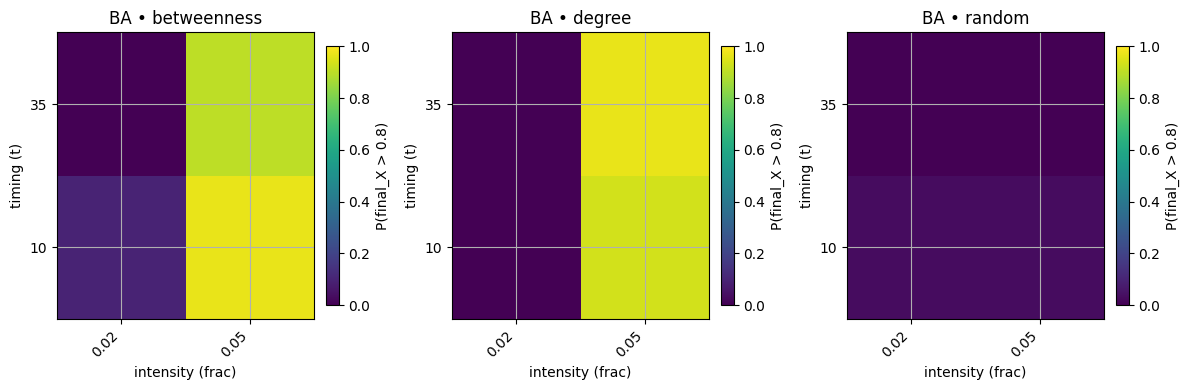

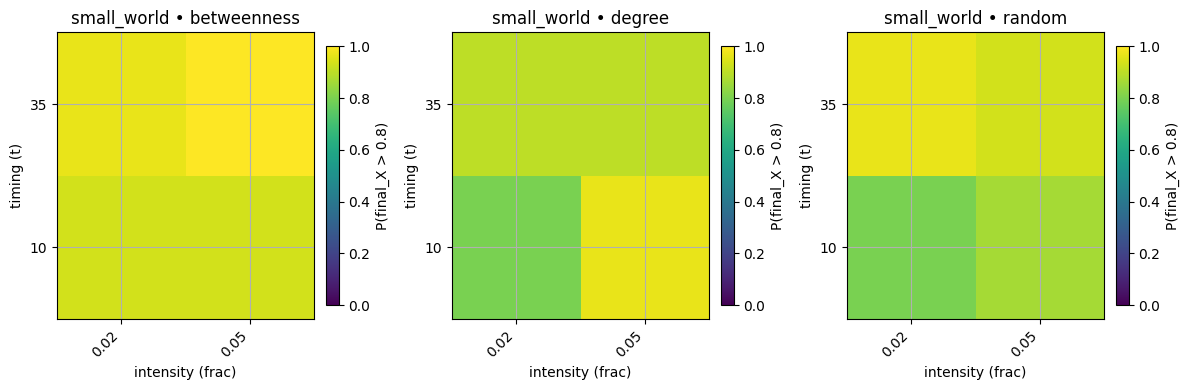

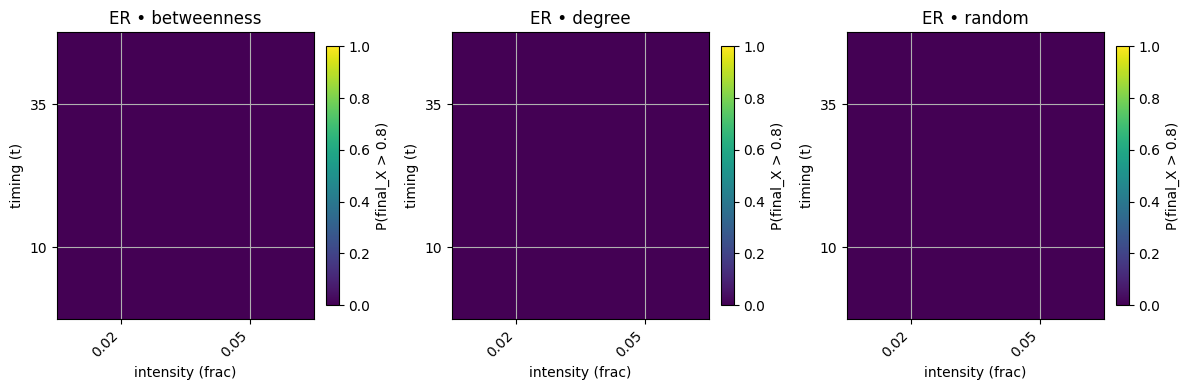

In [30]:
def plot_heatmaps_p_high(df, network="BA", strategies=None):
    d = df[df["network"] == network].copy()
    if strategies is not None:
        d = d[d["seed_strategy"].isin(strategies)]

    # drop baseline for the heatmap grid (timing=None doesn't map nicely)
    d = d[d["timing"].notna()]

    # compute tipping probability
    g = (d.groupby(["seed_strategy", "timing", "intensity"])["high_eq"]
           .mean()
           .reset_index(name="p_high"))

    strategies_order = list(g["seed_strategy"].unique())
    n = len(strategies_order)

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), squeeze=False)
    for i, strat in enumerate(strategies_order):
        ax = axes[0, i]
        sub = g[g["seed_strategy"] == strat]

        pivot = sub.pivot(index="timing", columns="intensity", values="p_high").sort_index()
        im = ax.imshow(
            pivot.values,
            aspect="auto",
            origin="lower",
            vmin=0.0,
            vmax=1.0,
        )


        ax.set_title(f"{network} • {strat}")
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels([f"{c:.2f}" for c in pivot.columns], rotation=45, ha="right")
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels([int(t) for t in pivot.index])

        ax.set_xlabel("intensity (frac)")
        ax.set_ylabel("timing (t)")

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="P(final_X > 0.8)")

    plt.tight_layout()
    plt.show()

# example
plot_heatmaps_p_high(df, network="BA")
plot_heatmaps_p_high(df, network="small_world")
plot_heatmaps_p_high(df, network="ER")

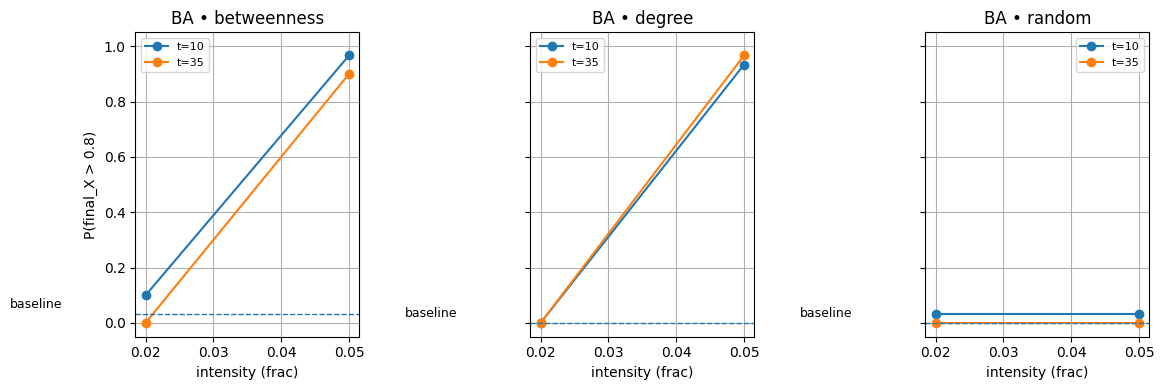

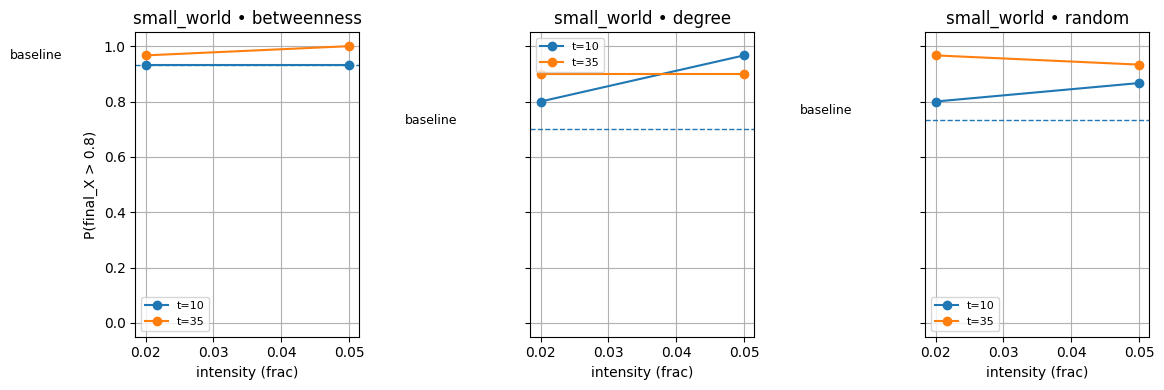

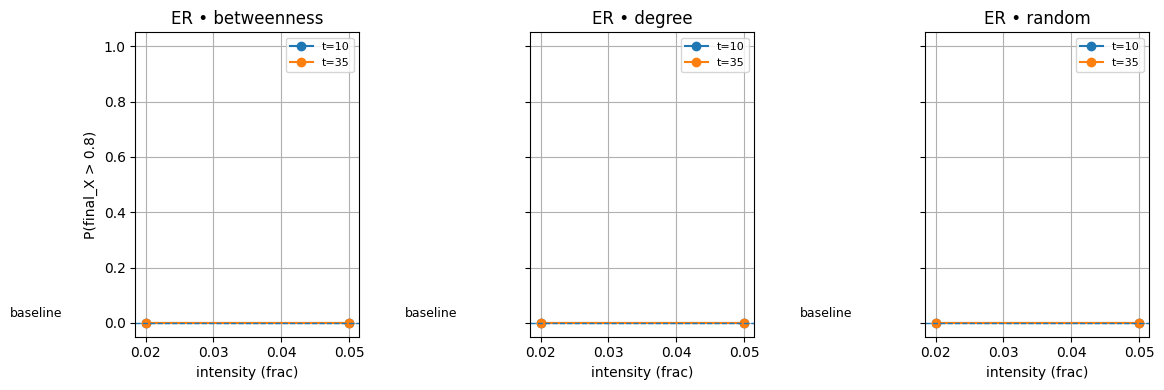

In [31]:
def plot_prob_vs_intensity_by_timing(df, network="BA", strategies=None):
    d = df[df["network"] == network].copy()
    if strategies is not None:
        d = d[d["seed_strategy"].isin(strategies)]

    # baseline as a horizontal reference line (per strategy)
    base = (d[d["timing"].isna()]
            .groupby("seed_strategy")["high_eq"].mean())

    d = d[d["timing"].notna()]

    g = (d.groupby(["seed_strategy", "timing", "intensity"])["high_eq"]
           .mean()
           .reset_index(name="p_high"))

    strategies_order = list(g["seed_strategy"].unique())
    n = len(strategies_order)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True, squeeze=False)

    for i, strat in enumerate(strategies_order):
        ax = axes[0, i]
        sub = g[g["seed_strategy"] == strat].sort_values(["timing", "intensity"])

        for t in sorted(sub["timing"].unique()):
            s2 = sub[sub["timing"] == t]
            ax.plot(s2["intensity"], s2["p_high"], marker="o", label=f"t={int(t)}")

        # baseline reference
        if strat in base.index:
            ax.axhline(base.loc[strat], linestyle="--", linewidth=1)
            ax.text(0.0, base.loc[strat] + 0.02, "baseline", fontsize=9)

        ax.set_title(f"{network} • {strat}")
        ax.set_xlabel("intensity (frac)")
        if i == 0:
            ax.set_ylabel("P(final_X > 0.8)")
        ax.set_ylim(-0.05, 1.05)
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# example
plot_prob_vs_intensity_by_timing(df, network="BA")
plot_prob_vs_intensity_by_timing(df, network="small_world")
plot_prob_vs_intensity_by_timing(df, network="ER")


In [32]:
def speed_heatmap_for_network(
    df,
    net,
    strategy="degree",
    timings=None,
    intensities=None,
    include_baseline=False,
):
    """
    Heatmap of median time_to_80 (time until X >= 0.8) for a given network + strategy.
    Cells with no cascades (no time_to_80) are marked with ×.

    df must include columns: network, seed_strategy, timing, intensity, time_to_80
    """
    sub = df[(df["network"] == net) & (df["seed_strategy"] == strategy)].copy()

    if not include_baseline:
        sub = sub[sub["timing"].notna()]  # drop baseline rows (timing=None)

    # Optional: restrict to specific timings/intensities (useful for consistent grids)
    if timings is not None:
        sub = sub[sub["timing"].isin(timings)]
    if intensities is not None:
        sub = sub[np.isclose(sub["intensity"], intensities).any(axis=0)] if hasattr(intensities, "__len__") else sub[sub["intensity"] == intensities]

    # median time among successful runs only
    # (NaN if nobody succeeded)
    speed_int = (
        sub.groupby(["intensity", "timing"])["time_to_80"]
           .median()
           .reset_index(name="median_time_to_80")
    )

    pivot = speed_int.pivot(index="intensity", columns="timing", values="median_time_to_80")

    # Sort axes nicely
    pivot = pivot.sort_index()                   # intensity ascending
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)  # timing ascending

    fig, ax = plt.subplots(figsize=(6, 4))

    im = ax.imshow(
        pivot.values,
        origin="lower",
        aspect="auto",
        cmap="plasma",
    )

    # Mark missing (no cascades)
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            if np.isnan(pivot.values[i, j]):
                ax.text(j, i, "×", ha="center", va="center",
                        color="white", fontsize=14, fontweight="bold")

    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels([str(c) for c in pivot.columns])
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels([f"{r:.2f}" for r in pivot.index])

    plt.colorbar(im, ax=ax, label="Median time to X ≥ 0.8 (successful runs)")
    ax.set_xlabel("Intervention time (t)")
    ax.set_ylabel("Intensity (fraction of total nodes)")
    ax.set_title(f"{net} • {strategy}: speed of adoption\n(× = no cascades)")

    plt.tight_layout()
    plt.show()


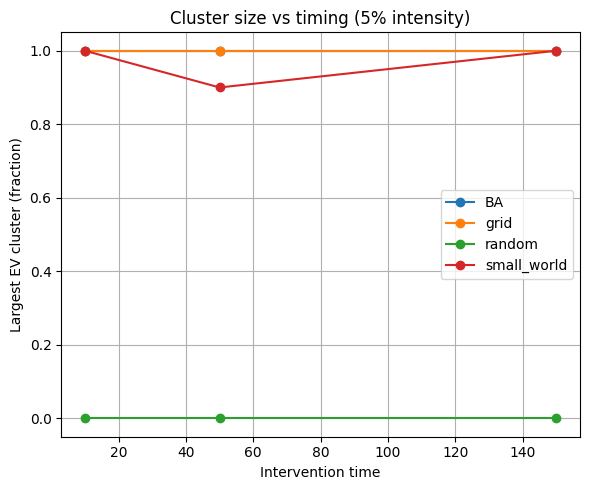

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

for net, grp in clusters_int.groupby("network"):
    sel = grp[grp["intensity"] == 0.05].sort_values("timing")
    ax.plot(sel["timing"], sel["mean_largest_cluster"], marker="o", label=net)

ax.set_xlabel("Intervention time")
ax.set_ylabel("Largest EV cluster (fraction)")
ax.set_title("Cluster size vs timing (5% intensity)")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
NETWORK_TYPES = ["WS", "BA", "ER"]   # match what run_network_trial expects

def base_params_for(net, BASE):
    """
    Ensure BASE has whatever run_network_trial needs for each net.
    Adjust these defaults to match your model's signature.
    """
    bp = dict(BASE)  # copy

    # Common
    bp.setdefault("n_nodes", 250)

    # BA typically needs m
    if net == "BA":
        bp.setdefault("m", 2)

    # WS/ER typically need p (rewire / edge prob)
    if net in ("WS", "ER"):
        bp.setdefault("p", 0.05)

    # grid may not need m/p; keep harmless defaults if present
    return bp

all_df = []
all_raw = {}

for net in NETWORK_TYPES:
    bp = base_params_for(net, BASE)

    df_net, raw_net = sweep_small_perturbations_X0(
        network_type=net,
        X0_vals=X0_VALS,
        I0=I0_TARGET,
        base_params=bp,
        eps=0.02,
        mode="plusminus",
        N_seeds=N_SEEDS,
        T=T_FINAL,
        low_thr=LOW_THR,
        high_thr=HIGH_THR,
        strategy_choice_func="logit",
        tau=bp.get("tau", 3.0),
    )

    df_net["net"] = net
    all_df.append(df_net)
    all_raw[net] = raw_net

df_all = pd.concat(all_df, ignore_index=True)
df_all.head()


,network_type,I0,X0,eps,X0_plus,mean0,mean_plus,delta_mean_plus,delta_mean_plus_std,p_low0,...,delta_mean_minus,delta_mean_minus_std,p_low_minus,p_mid_minus,p_high_minus,delta_p_high_minus,delta_p_low_minus,d_mean_dX0,d_p_high_dX0,net
0,WS,0.3,0.00,0.02,0.02,0.0000,0.00000,0.00000,0.000000,1.0000,...,0.00000,0.000000,1.0000,0.000,0.0000,0.000,0.0000,0.00000,0.0000,WS
1,WS,0.3,0.05,0.02,0.07,0.0000,0.00075,0.00075,0.006666,1.0000,...,0.00000,0.000000,1.0000,0.000,0.0000,0.000,0.0000,0.01875,0.0000,WS
2,WS,0.3,0.10,0.02,0.12,0.0265,0.10925,0.08275,0.268882,0.9750,...,0.02575,0.156147,1.0000,0.000,0.0000,0.025,-0.0250,2.71250,2.5000,WS
3,WS,0.3,0.15,0.02,0.17,0.3080,0.30800,0.00000,0.000000,0.6750,...,0.11025,0.309919,0.7875,0.025,0.1875,0.100,-0.1125,2.75625,2.5000,WS
4,WS,0.3,0.20,0.02,0.22,0.4695,0.54775,0.07825,0.254366,0.4875,...,0.12575,0.330503,0.6125,0.075,0.3125,0.125,-0.1250,5.10000,4.6875,WS


In [ ]:
df_all[df_all["net"] == "WS"]

,network_type,I0,X0,eps,X0_plus,mean0,mean_plus,delta_mean_plus,delta_mean_plus_std,p_low0,...,delta_mean_minus,delta_mean_minus_std,p_low_minus,p_mid_minus,p_high_minus,delta_p_high_minus,delta_p_low_minus,d_mean_dX0,d_p_high_dX0,net
21,WS,0.3,0.00,0.02,0.02,0.00000,0.00000,0.00000,0.000000,1.0000,...,0.00000,0.000000,1.0000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,WS
22,WS,0.3,0.05,0.02,0.07,0.00000,0.00075,0.00075,0.006666,1.0000,...,0.00000,0.000000,1.0000,0.0000,0.0000,0.000,0.0000,0.01875,0.0000,WS
23,WS,0.3,0.10,0.02,0.12,0.02650,0.10925,0.08275,0.268882,0.9750,...,0.02575,0.156147,1.0000,0.0000,0.0000,0.025,-0.0250,2.71250,2.5000,WS
24,WS,0.3,0.15,0.02,0.17,0.30800,0.30800,0.00000,0.000000,0.6750,...,0.11025,0.309919,0.7875,0.0250,0.1875,0.100,-0.1125,2.75625,2.5000,WS
25,WS,0.3,0.20,0.02,0.22,0.46950,0.54775,0.07825,0.254366,0.4875,...,0.12575,0.330503,0.6125,0.0750,0.3125,0.125,-0.1250,5.10000,4.6875,WS
26,WS,0.3,0.25,0.02,0.27,0.66700,0.84350,0.17650,0.406568,0.2875,...,0.00000,0.000000,0.2875,0.0875,0.6250,0.000,0.0000,4.41250,4.6875,WS
27,WS,0.3,0.30,0.02,0.32,0.93350,0.95575,0.02225,0.140035,0.0500,...,0.09000,0.274390,0.1125,0.0750,0.8125,0.100,-0.0625,2.80625,3.1250,WS
28,WS,0.3,0.35,0.02,0.37,0.99375,0.99425,0.00050,0.004444,0.0000,...,0.03800,0.186349,0.0375,0.0250,0.9375,0.050,-0.0375,0.96250,1.2500,WS
29,WS,0.3,0.40,0.02,0.42,0.99425,1.00000,0.00575,0.051107,0.0000,...,0.00000,0.000000,0.0000,0.0125,0.9875,0.000,0.0000,0.14375,0.3125,WS
30,WS,0.3,0.45,0.02,0.47,1.00000,1.00000,0.00000,0.000000,0.0000,...,0.00000,0.000000,0.0000,0.0000,1.0000,0.000,0.0000,0.00000,0.0000,WS


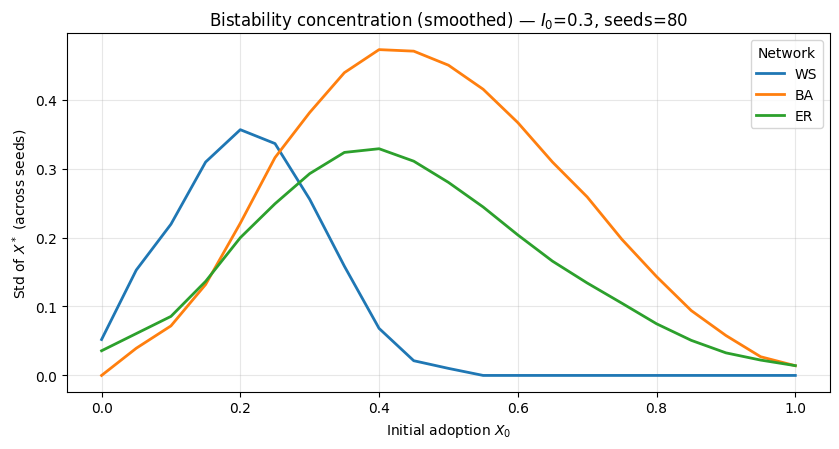

In [ ]:
SMOOTH_WINDOW = 5   # try 3–5; must be odd for symmetry

plt.figure(figsize=(8.5, 4.6))

for net in NETWORK_TYPES:
    xs, stds = [], []
    for X0 in sorted(X0_VALS):
        f0 = all_raw[net][(float(X0), "base")]
        xs.append(float(X0))
        stds.append(np.std(f0))

    s = pd.Series(stds)
    stds_smooth = s.rolling(
        window=SMOOTH_WINDOW,
        center=True,
        min_periods=1
    ).mean()

    plt.plot(xs, stds_smooth, linewidth=2, label=net)

plt.xlabel("Initial adoption $X_0$")
plt.ylabel("Std of $X^*$ (across seeds)")
plt.title(f"Bistability concentration (smoothed) — $I_0$={I0_TARGET}, seeds={N_SEEDS}")
plt.grid(True, alpha=0.3)
plt.legend(title="Network")
plt.tight_layout()
plt.show()